### Explore Batter Data

In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

#Sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import ensemble

#Display
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)
%matplotlib inline

In [2]:
batter_profiles = pd.read_csv('milb_batter_summaries.csv')
batter_seasons = pd.read_csv('milb_all_batter_seasons.csv')

In [3]:
len(batter_profiles.milb_id.unique())

17525

__Helper Functions__

Add Useful Data Fields

In [4]:
def add_season_number(df):
    first_year = pd.DataFrame()
    first_year['FirstYear'] = df.groupby(['milb_id']).min()['Year']
    first_year = first_year.reset_index()
    df = df.merge(first_year, how = 'outer')
    
    df['SeasonNumber'] = df['Year'] - df['FirstYear'] + 1
    #df = df.drop('First_Year',axis = 1)
    return df

def add_success_year(df):
    success_year = pd.DataFrame()
    success_year['FirstYear'] = df.groupby(['milb_id']).min()['Year']
    first_year = first_year.reset_index()
    df = df.merge(first_year, how = 'outer')
    
    df['SeasonNumber'] = df['Year'] - df['FirstYear'] + 1
    #df = df.drop('First_Year',axis = 1)
    return df


Add Stat Calulation Functions

In [5]:
## Batting Average
# Number of Hits (divided by) Number of At Bats

# Calculate the number of single from other hit data
def calc_singles(df):
    df['1B'] = df['H'] - df['2B'] - df['3B'] - df['HR']
    return df

def calc_BA(df):
    ba_series = df['H']/df['AB']
    return ba_series
    
## Slugging Percentage
# Number of (Singles + [2 x Doubles] +[ 3 x Triples] + [4 x Home Runs]) divided by At Bats  
def calc_SLG(df):
    slg_series = (df['1B'] + 2*df['2B'] + 3*df['3B'] + 4*df['HR']) / df['AB']
    return slg_series

## On Base Percentage
# (Hits + Walks + Hit-By-Pitch) divided by (At Bats + Walks+ Hit-By-Pitch + Sac Flys)
def calc_OBP(df):
    obp_series = (df['H'] + df['BB'] + df['HBP']) \
        / (df['AB'] + df['BB'] + df['HBP']+df['SF']) 
    return obp_series

## On Base Plus Slugging 
def calc_OPS(df):
     # On Base Plus Slugging 
    ops_series = calc_OBP(df) + calc_SLG(df)
    return ops_series

Add Aggregation Function

In [6]:
# Aggregate year by year stats into full career data.
# Requires the recalculation of rate based stats from their definitions.
def make_season_stats(df):
    
    counting_stats = ['G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB',
       'CS', 'BB', 'SO','TB', 'GDP', 'HBP','SH', 'SF', 'IBB']
    
    
    if 'LevNum' in df.columns:
        df['LevWeight'] = df['LevNum']*df['PA']
    
    
    # Make groupby object to only do aggregation once
    grouped_obj = df.groupby(['milb_id','Year'])
    
    df_grouped = grouped_obj.sum()
    
    df_grouped['1B'] = calc_singles(df_grouped)
    
    # Batting Average 
    df_grouped['BA'] = calc_BA(df_grouped)
    
    # On Base Percentage
    df_grouped['OBP'] = calc_OBP(df_grouped)
    
    # Slugging Percentage
    df_grouped['SLG'] = calc_SLG(df_grouped)
    
    # On Base Plus Slugging 
    df_grouped['OPS'] = calc_OPS(df_grouped)
    
    # Other BIO 
    # Fields where max is most important 
    test_fields = ['Age','FirstYear',
                   'SeasonNumber','SuccessYear']
    for tf in test_fields:
        if tf in df_grouped.columns:
            df_grouped[tf] = grouped_obj[tf].max()
            
    # fields where min is most importand
    test_fields2 = ['AgeDif']
    for tf in test_fields2:
        if tf in df_grouped.columns:
            df_grouped[tf] = grouped_obj[tf].min()
                  
    # Minor League Level Attributs
    if 'LevNum' in df.columns:
        df_grouped['LevWeighted'] = df_grouped['LevWeight']/df_grouped['PA']
        
        df_grouped['LevCount'] = grouped_obj.count()['Lev']
        df_grouped.drop('LevWeight', axis=1, inplace=True)
    
    df_grouped.reset_index(inplace=True)
    
    return df_grouped


Function for creating rate stats

In [7]:
def make_rate_stats(df):
    
    df['HR_rate'] = df['HR']/df['PA']
    df['BB_rate'] = df['BB']/df['PA']
    df['SO_rate'] = df['SO']/df['PA']
    df['IBB_rate'] = df['IBB']/df['PA']
    df['SB_rate'] = df['SB']/df['PA'] #None standard definition
    df['SB_percentage'] = df['SB']/(df['SB']+df['CS'])
    df.loc[np.isnan(df['SB_percentage']),['SB_percentage']] = 0
    
    df['GDP_rate'] = df['GDP']/df['PA']
    df['SH_rate'] = df['SH']/df['PA']
    df['SF_rate'] = df['SF']/df['PA']
    df['HBP_rate'] = df['HBP']/df['PA']
    
    
    df['SB_percentage']
    
    return df

__Filtering and Aggregation__

In [105]:
batter_seasons_filt = deepcopy(batter_seasons)

# Drop Aggregated Seasons. Will Recompute
batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt.Tm.str.contains('Teams') == False]

In [106]:
# Map Each League to a level
lev_dict = {'FRk':0,'Rk':1,'A-':2,'A':3,'A+':4,'AA':5,'AAA':6}
level_map = pd.Series(batter_seasons_filt.loc[:,('Lev')].map(lev_dict))
batter_seasons_filt['LevNum'] = level_map

# Drop Leagues that are "Atypical"
weird_leagues = ['Ind','Rk','FRk','WRk','FgW','Fal','Fgn','Wtr']
batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt['Lev'].isin(weird_leagues) == False]
batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt['Lg'] != 'MEX']

In [78]:
# Remove Players Who had their first season before 1990.
batter_seasons_filt = add_season_number(batter_seasons_filt)
batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt['FirstYear'] > 1990]

batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt['FirstYear'] < 2012]

In [79]:
# Remove Seasons that occured after player made the majors
majors_df = batter_seasons_filt[
    batter_seasons_filt.Lev == 'MLB'][['milb_id','Year']]

mlb_debuts = majors_df.groupby('milb_id').min().reset_index()
mlb_debuts.rename(columns={'Year':'SuccessYear'},inplace=True)

batter_seasons_filt = batter_seasons_filt.merge(
    mlb_debuts, how = 'left',on= 'milb_id')

batter_seasons_filt = batter_seasons_filt[
    (batter_seasons_filt['SuccessYear'] > batter_seasons_filt['Year']) | 
    pd.isnull(batter_seasons_filt['SuccessYear'])] 


In [80]:
batter_seasons_total = make_season_stats(batter_seasons_filt)
batter_seasons_total = make_rate_stats(batter_seasons_total)

In [81]:
## Add dependent variable
batter_seasons_total = batter_seasons_total.merge(
    batter_profiles.loc[:,['milb_id','mlb']],
    how = 'left',
    on = 'milb_id')

In [82]:
bst_test = deepcopy(batter_seasons_total)

In [83]:
bst_test = bst_test.loc[bst_test['SeasonNumber'] == 2,:]
bst_test = bst_test.loc[bst_test['PA'] > 150,:]

### Model Stuff

In [84]:
test_cols = ['milb_id','LevWeighted','AgeDif','PA',
             'BA','OBP','SLG','HR_rate',
             'BB_rate','SO_rate','IBB_rate',
             'SB_rate','SB_percentage','GDP_rate',
             'SH_rate','HBP_rate']

X1 = bst_test.loc[:,test_cols]
y1 = bst_test.loc[:,['mlb']]

In [85]:
# Baseline Prediction
#sum(y1)/len(y1)
baseline1 = sum(y1.values)/len(y1.values)
baseline1

array([ 0.24835041])

In [98]:
X1_train, X1_test, y1_train, y1_test = model_selection.train_test_split(
    X1, y1, test_size=0.3)

In [99]:
lm1 = linear_model.LogisticRegression()
lm1.fit(X1_train.iloc[:,1:],y1_train)
pred_proba1 = lm1.predict_proba(X1_test.iloc[:,1:])

/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [108]:
metrics.log_loss(y1_test,pred_proba1)

0.40460628437885288

In [124]:
# Accuracy
print(metrics.accuracy_score(y1_test,np.round(pred_proba1[:,1])))

0.80767430978


In [128]:
metrics.precision_recall_fscore_support(y1_test,np.round(pred_proba1[:,1]),labels = [0,1])

(array([ 0.83904867,  0.63525836]),
 array([ 0.92669517,  0.418     ]),
 array([ 0.88069666,  0.50422195]),
 array([1637,  500]))

In [100]:
pred_proba_df = pd.DataFrame(pred_proba1,index = X1_test.index)

In [101]:
pred_proba_df['id'] = X1_test['milb_id']
pred_proba_df['truth'] = y1_test
pred_proba_df.sort_values(1,ascending = False)

In [104]:
#pred_proba_df.sort_values(1,ascending=False)

In [93]:
prec, recall, thresholds = metrics.precision_recall_curve(
    y1_test,pred_proba1[:,1])

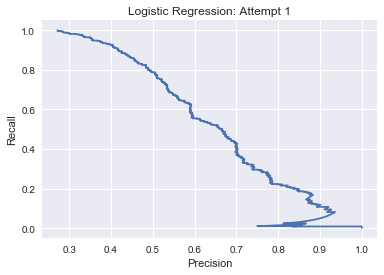

In [94]:
plt.plot(prec[0:-1], recall[0:-1])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Logistic Regression: Attempt 1')

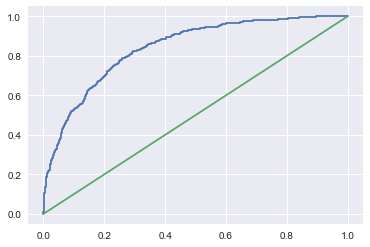

In [95]:
fpr, tpr, thresholds = metrics.roc_curve(y1_test,pred_proba1[:,1])
plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100))

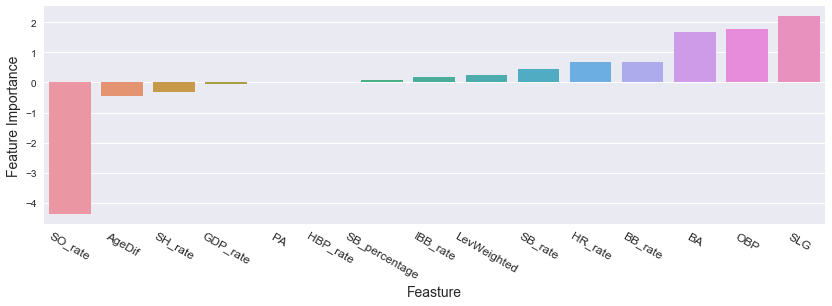

In [136]:
f_Series = pd.Series(lm1.coef_[0],index = X1.columns[1:]).sort_values()

plt.figure(figsize=(14, 4))
g = sns.barplot(x = f_Series.index,y = f_Series)
g.set_xticklabels(f_Series.index, rotation=-30,size=12)
plt.ylabel('Feature Importance',size=14);
plt.xlabel('Feasture',size=14);


In [131]:
rf1 = ensemble.RandomForestClassifier()
rf1.fit(X1_train.iloc[:,1:],y1_train)
pred_proba_rf1 = rf1.predict_proba(X1_test.iloc[:,1:])

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [132]:
metrics.precision_recall_fscore_support(y1_test,np.round(pred_proba_rf1[:,1]),labels = [0,1])

(array([ 0.83524904,  0.64193548]),
 array([ 0.93219304,  0.398     ]),
 array([ 0.88106236,  0.49135802]),
 array([1637,  500]))

In [133]:
prec, recall, thresholds = metrics.precision_recall_curve(
    y1_test,pred_proba1[:,1])

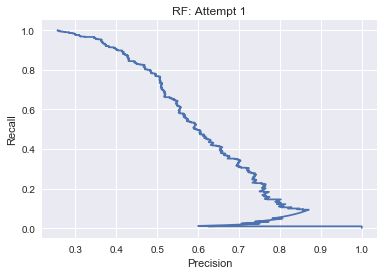

In [135]:
plt.plot(prec[0:-1], recall[0:-1])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('RF: Attempt 1')

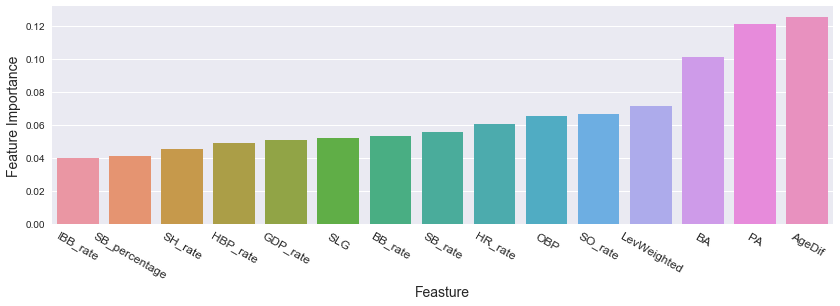

In [139]:
f_Series = pd.Series(rf1.feature_importances_,index = X1.columns[1:]).sort_values()

plt.figure(figsize=(14, 4))
g = sns.barplot(x = f_Series.index,y = f_Series)
g.set_xticklabels(f_Series.index, rotation=-30,size=12)
plt.ylabel('Feature Importance',size=14);
plt.xlabel('Feasture',size=14);

In [141]:
pred_proba_df = pd.DataFrame(pred_proba_rf1,index = X1_test.index)
pred_proba_df['id'] = X1_test['milb_id']
pred_proba_df['truth'] = y1_test
pred_proba_df.sort_values(1,ascending = False)

,0,1,id,truth
24157,0.0,1.0,navarr001dio,1
21303,0.0,1.0,mathis001jef,1
8445,0.0,1.0,delluc001dav,1
19610,0.0,1.0,lockwo001mic,0
5231,0.0,1.0,caruso001mic,1
33427,0.0,1.0,swishe001nic,1
6145,0.0,1.0,cirill001jef,1
19746,0.0,1.0,longor001eva,1
1344,0.0,1.0,aubrey001rob,1
20407,0.0,1.0,magee001wen,1


In [29]:
# 'CREATE TABLE IF NOT EXISTS BatterSeasons (
#     Year int DEFAULT NULL,
#     Age int DEFAULT NULL,
#     AgeDif float DEFAULT NULL,
#     G int DEFAULT NULL,
#     PA int DEFAULT NULL,
#     AB int DEFAULT NULL,
#     R int DEFAULT NULL,
#     H int DEFAULT NULL,
#     2B int DEFAULT NULL,
#     3B int DEFAULT NULL,
#     HR int DEFAULT NULL,
#     RBI int DEFAULT NULL,
#     SB int DEFAULT NULL,
#     CS int DEFAULT NULL,
#     BB int DEFAULT NULL,
#     SO int DEFAULT NULL,
#     BA float DEFAULT NULL,
#     OBP float DEFAULT NULL,
#     SLG float DEFAULT NULL,
#     OPS float DEFAULT NULL,
#     TB int DEFAULT NULL,
#     GDP int DEFAULT NULL,
#     HBP int DEFAULT NULL,
#     SH int DEFAULT NULL,
#     SF int DEFAULT NULL,
#     IBB int DEFAULT NULL,
#     Tm varchar(20) NOT NULL,
#     Lg varchar(20) NOT NULL,
#     Lev varchar(20) NOT NULL,
#     Aff varchar(20) NOT NULL,
#     mlb_id varchar(20) NOT NULL,
#     milb_id varchar(20) NOT NULL],
#     playerID varchar(20) NOT NULL,
#     yearID int NOT NULL,
#     gameNum varchar(20) NOT NULL,
#     gameID varchar(12) DEFAULT NULL,
#     teamID text DEFAULT NULL,
#     lgID text DEFAULT NULL,
#     GP varchar(20) DEFAULT NULL,
#     startingPos varchar(20) DEFAULT NULL,
#     PRIMARY KEY (playerID,yearID,gameNum)
# );'